# Hierarchical Linear Regression (Radon Contamination dataset)

In this example we want to revisit the classical example of hierarchical linear regression model based on the dataset of the *Radon Contamination* by Gelman and Hill. In particular, we want to show how to easy is to port the [`pymc`](https://docs.pymc.io/en/v3/) models, presented in the very complete article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html), to [`bambi`](https://bambinos.github.io/bambi/main/index.html) using the formula specification for the models.

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

az.style.use("arviz-darkgrid")
np.random.default_rng(8924)

%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = "svg"

## Read Data

Let us load the data into a pandas dataframe.

In [2]:
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"

srrs2 = pd.read_csv(path)

## Preprocess Data

Let us start by preprocessing the data as done in the article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html). We want to keep the same notation as in the article.

In [3]:
# TODO: Organize this pre-processing steps and keep just the relevant ones.

# Filter data for state `MN`
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

# Compute fips
srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips

# Get city data
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

# Merge data
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

# Get lookup table for counties
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

# local copies of variables
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

srrs_mn.sort_values(by="floor", inplace=True)

# Map 0 -> Basement and 1 -> Floor
srrs_mn["floor"] = srrs_mn["floor"].map({0: "Basement", 1: "Floor"})

## EDA

Let us do some exploratory data analysis. To get a glimpse of the data we are going to use. First Let us see global `log_radon` distribution.

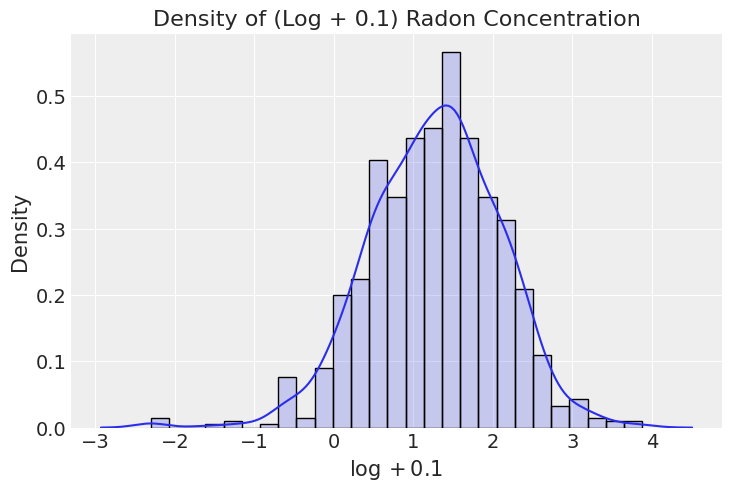

In [4]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon",  alpha=0.2, stat="density", data=srrs_mn, ax=ax)
sns.kdeplot(x="log_radon", data=srrs_mn, ax=ax)
ax.set(title="Density of (Log + 0.1) Radon Concentration", xlabel="$\log + 0.1$", ylabel="Density");

Let us now se the split per `floor`:

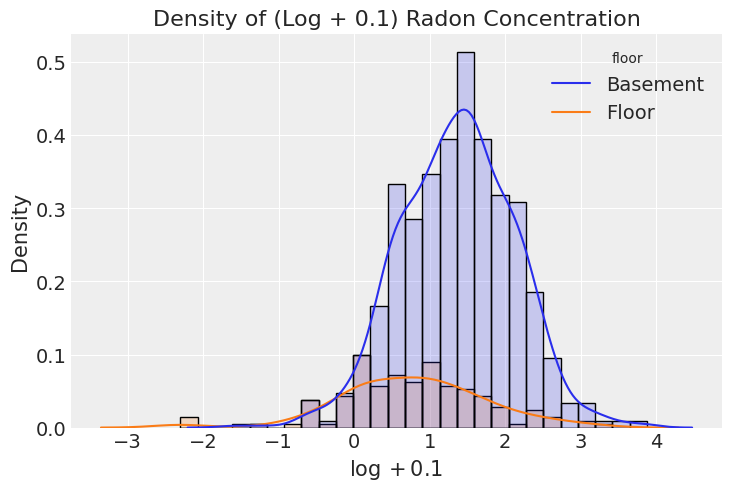

In [5]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon", hue="floor", alpha=0.2, stat="density", data=srrs_mn, ax=ax)
sns.kdeplot(x="log_radon", hue="floor", data=srrs_mn, ax=ax)
ax.set(title="Density of (Log + 0.1) Radon Concentration", xlabel="$\log + 0.1$", ylabel="Density");

Next, let us count the number of counties.

In [6]:
print(f"Number of counties: {srrs_mn['county'].unique().size}")

Number of counties: 85


Let us dig deeper into the distribution of radon per county and floor level.

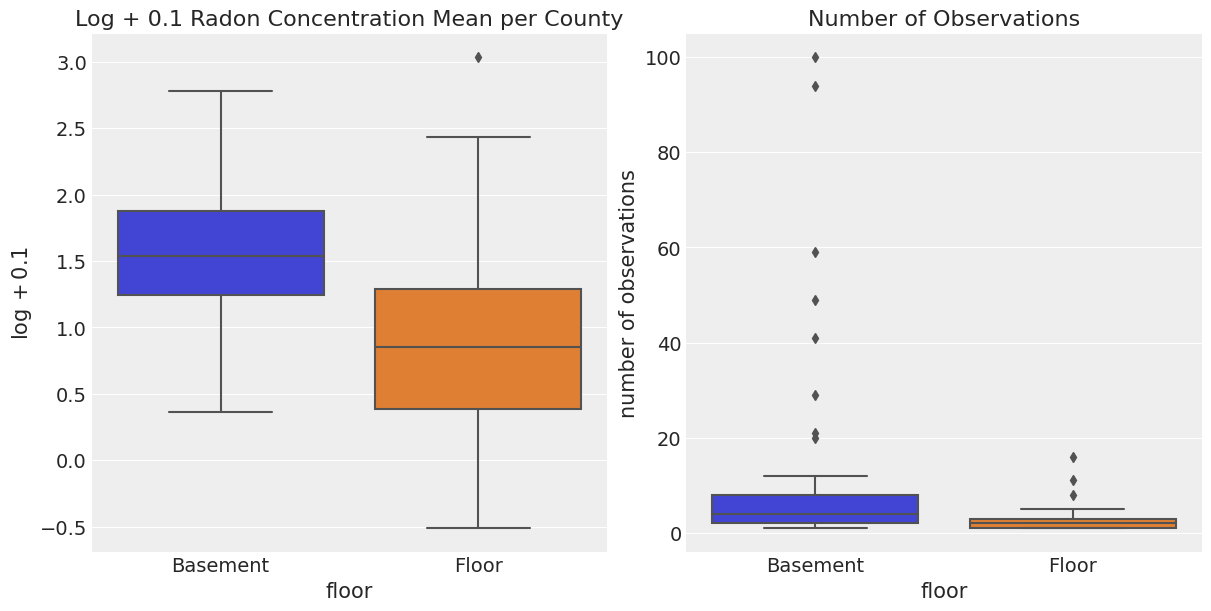

In [7]:
log_radon_county_agg  = srrs_mn \
    .groupby(["county", "floor"], as_index=False) \
    .agg(
        log_radon_mean=("log_radon", "mean"),
        n_obs=("log_radon", "count")
    )

fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(12, 6), layout="constrained")
sns.boxplot(x="floor", y="log_radon_mean", data=log_radon_county_agg, ax=ax[0])
ax[0].set(title="Log + 0.1 Radon Concentration Mean per County", ylabel="$\log + 0.1$");
sns.boxplot(x="floor", y="n_obs", data=log_radon_county_agg, ax=ax[1])
ax[1].set(title="Number of Observations", xlabel="floor", ylabel="number of observations");

We see that there are some counties with a lot of basement observations. This can create some bias when computing simple statistics to compare across counties. Moreover, not all `county` and `floor` combinations are present in the dataset. For example:

In [8]:
assert srrs_mn.query("county == 'YELLOW MEDICINE' and floor == 'Floor'").empty

## Models: Conventional Approaches

### Complete Pooling

Let us start by considering the complete pooling model on which we treat all counties the same and estimate a single radon level for every floor level. That is, We want to estimate the intercept ($\alpha$) and the slope ($\beta$) parameters for the equation:

$$y_i = \alpha + \beta x_i + \varepsilon_i, \quad \text{with} \: i=1, \cdots, n$$

where $y_i$ represents the `log_radon`, $x_i$ represents the `floor` and $\varepsilon_i \sim N(0, \sigma^2_y)$ represents the `radon` noise. As we want to make the results of this notebook comparable with the original PyMC article, we use the full one-hot-encoding of the `floor` variable. This means that we do not need to add an intercept variable, i.e. we set $\alpha$ to zero. Besides the model specification, we also need to set prior distributions for $\beta$ and $\sigma$. We consider the following (as in the PyMC article):

$$
\begin{align*}
\beta & \sim N(0, 10^{2}) \\
\sigma & \sim Exp(1.0)
\end{align*}
$$

Let us now write the Bambi model:

In [9]:
pooled_priors = {
    "floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

pooled_model = bmb.Model(
    formula="log_radon ~ 0 + floor",
    data=srrs_mn,
    priors=pooled_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
    noncentered=False,
)

pooled_model

Formula: log_radon ~ 0 + floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

Here are some remarks:

- The formula for the model is `log_radon ~ 0 + floor`. The `0` at the beginning makes sure we remove the intercept.
- We use a non-centered parameterization of the model and do not scale the data just to make the results comparable with the original PyMC article.

Let us fit he model now:

In [10]:
pooled_results = pooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, floor]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


Let us see the graph representation of the model:

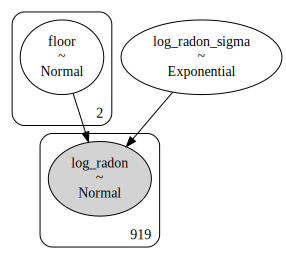

In [11]:
pooled_model.graph()

Now we can examine the posterior distribution of the model parameters:

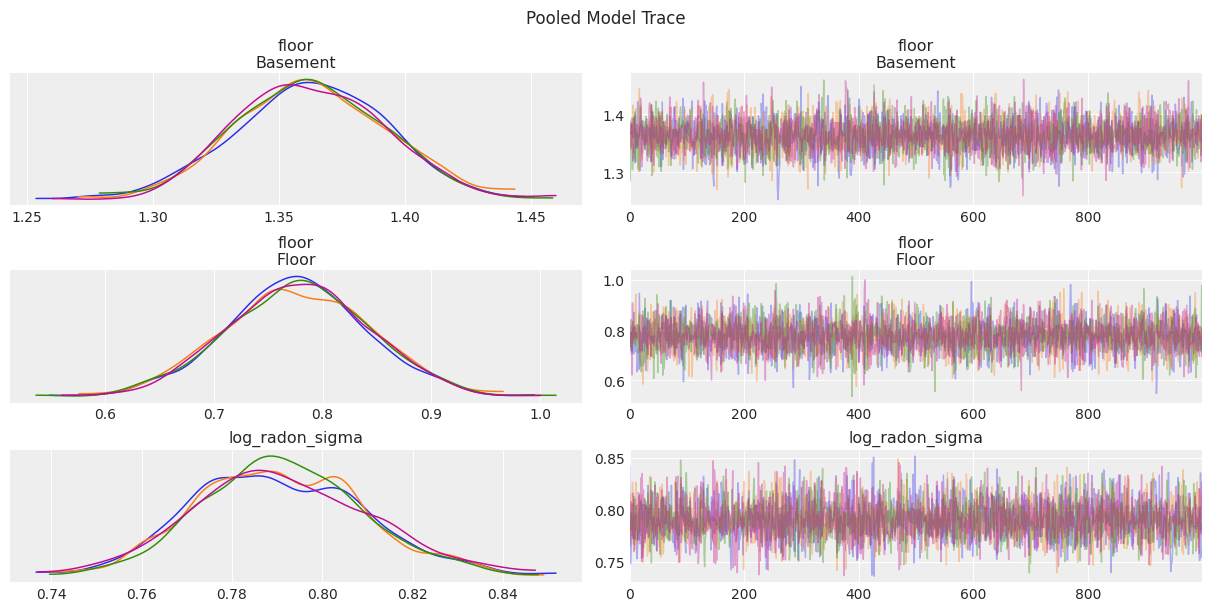

In [12]:
az.plot_trace(data=pooled_results, compact=False);
plt.suptitle("Pooled Model Trace");

We can also plot the distribution of each `floor` level parameter in the same plot.

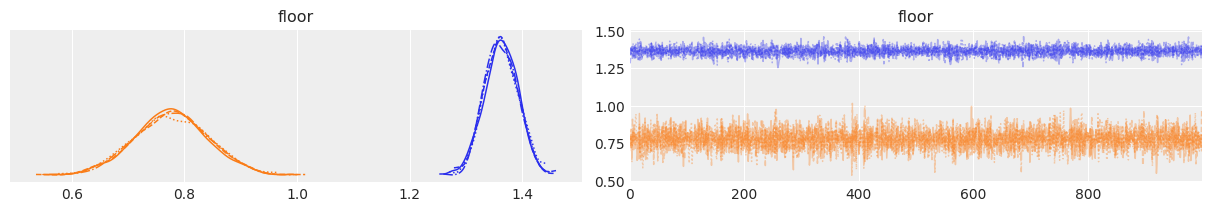

In [13]:
az.plot_trace(data=pooled_results, var_names=["floor"], compact=True);

We can now see some summary statistics. 

In [14]:
az.summary(data=pooled_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
floor[Basement],1.363,0.029,1.308,1.416,0.000,0.000,5148.0,2986.0,1.0
floor[Floor],0.777,0.065,0.656,0.904,0.001,0.001,4925.0,2972.0,1.0
log_radon_sigma,0.791,0.019,0.757,0.828,0.000,0.000,5381.0,2714.0,1.0


### No Pooling

Next, we consider the model in which radon is modeled for each `county` and `floor` combination independently, i.e. 

$$y_i = \alpha_{j[i]} + \beta x_i + \varepsilon_i \quad \text{where} \: j = 1,\ldots,85$$

As above, we actually set $\alpha_{j[i]} = 0$ (as we consider the full one-hot-encoding of the variables). Note that for in this case $x_i$ now represents the product of the floor level times the county (as indicator functions). To specify this model in Bambi we can use the formula `log_radon ~ 0 + county:floor`. Note that we are removing the intercept with the `0` term and `county:floor` is the multiplicative interaction between `county` and `floor`. We consider similar priors as above. Let us run the Baby model:

In [15]:
unpooled_priors = {
    "county:floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

unpooled_model = bmb.Model(
    formula="log_radon ~ 0 + county:floor",
    data=srrs_mn,
    priors=unpooled_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
    noncentered=False,
)

unpooled_model

Formula: log_radon ~ 0 + county:floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    county:floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [16]:
unpooled_results = unpooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, county:floor]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


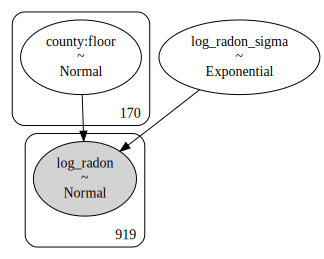

In [17]:
pm.model_to_graphviz(unpooled_model.backend.model)

From the graph representation of the model we see that the we are estimating $170 = 82 \times 2$ parameters from the `county:floor` interaction. Let us now compute the summary statistics of the model.

In [18]:
unpooled_summary = az.summary(data=unpooled_results)

We can now plot the posterior distribution mean of the beta coefficients against the observed values.

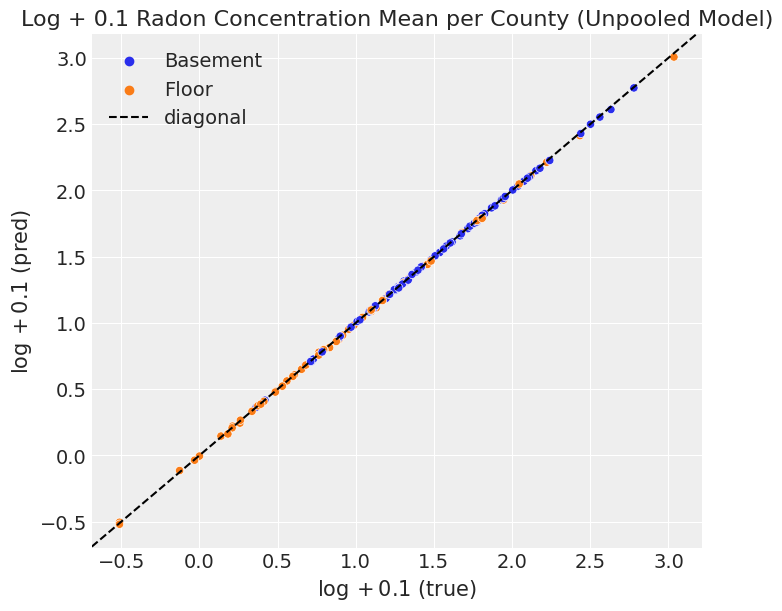

In [19]:
# Get county and floor names from summary table
var_mapping = unpooled_summary \
    .iloc[:-1] \
    .reset_index(drop=False) \
    ["index"] .str.slice(13, -1).str.split(",").apply(pd.Series)

var_mapping.rename(columns={0: "county", 1: "floor"}, inplace=True)
var_mapping["county"] = var_mapping["county"].str.strip()
var_mapping["floor"] = var_mapping["floor"].str.strip()
var_mapping.index = unpooled_summary.iloc[:-1].index
    
# merge with observed values
unpooled_summary_2 = pd.concat([var_mapping, unpooled_summary.iloc[:-1]], axis=1)


fig, ax = plt.subplots(figsize=(7, 6))
unpooled_summary_2 \
    .merge(right=log_radon_county_agg, on=["county", "floor"], how="left") \
    .pipe((sns.scatterplot, "data"),
        x="log_radon_mean",
        y="mean",
        hue="floor",
        ax=ax
    )
ax.axline(xy1=(1.0, 1.0), slope=1.0, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(
    title="Log + 0.1 Radon Concentration Mean per County (Unpooled Model)",
    xlabel="$\log + 0.1$ (true)",
    ylabel="$\log + 0.1$ (pred)",
);

As expeced, the values strongly concentrated along the diagonal.

We can now plot the mean and hdi of the posterior distribution of the model parameters:

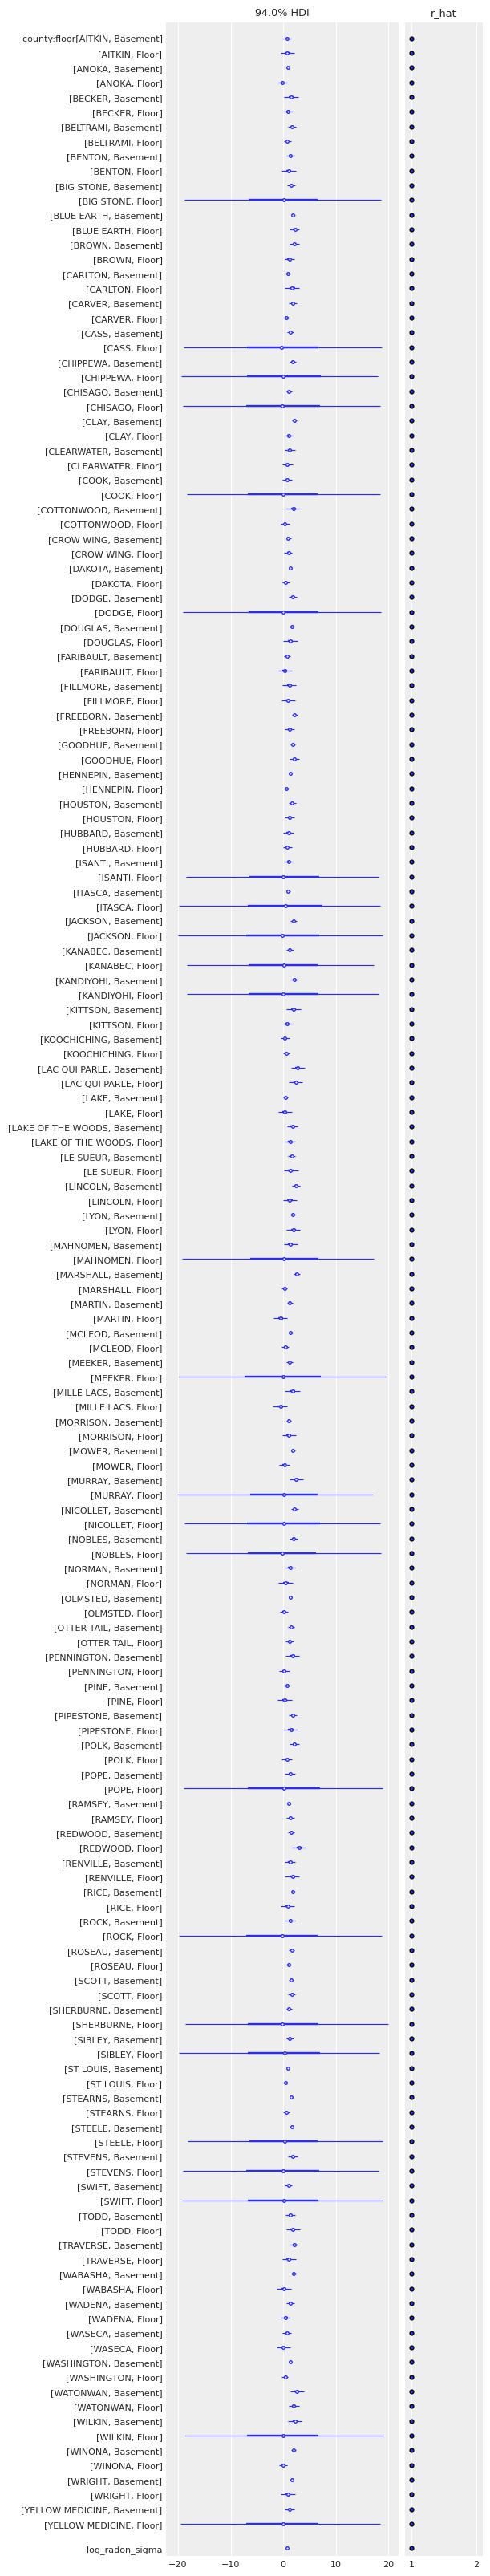

In [20]:
az.plot_forest(data=unpooled_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

Note how for the combination `county == 'YELLOW MEDICINE' and floor == 'Floor'` where we do not have any observations, the model can still generate predictions which are essentially coming from the prior distributions, which explains the large hdi intervals.

## Multilevel and Hierarchical Models

In this section we are going to explore various types of hierarchical models.If you're familiar with the PyMC way of using hierarchies, the Bambi way (borrowed from mixed effects models way) may be a bit confusing in the beginning, but as we will see, the notation is very convenient. A good explanation is found in Chapter 16 from Bayes Rules book, specifically section 16.3.2. Moreover, you can also take a look into the [Bambi examples section](https://bambinos.github.io/bambi/main/examples.html) where you can fin other use cases.

### Partial Pooling Model

We start with the *partial pooling model*, in which we estimate the radon level for each `county` (not considering `floor` for now) with the additional ingredient that we use a *hyper-prior* distribution over the intercept parameters. Concretely, we want to fit an intercept model

$$y_i = \alpha_{j[i]} + \varepsilon_i$$

where $\epsilon_i \sim N(0, \sigma_y^2)$ and the intercept random effect is parametrized as $\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$. The hyper-prior is specified as 

$$
\begin{align*}
\mu_{\alpha} & \sim N(0, 10^{2}) \\
\sigma_{\alpha} & \sim Exp(1.0)
\end{align*}
$$

Let us see how to specify this model in Bambi:

In [21]:
# We can add the hyper-priors inside the prior dictionary parameter of the model constructor
partial_pooling_priors = {
    "Intercept": bmb.Prior("Normal", mu=0.0, sigma=10),
    "1|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

partial_pooling_model = bmb.Model(
    "log_radon ~ 1 + (1|county)", 
    srrs_mn, 
    priors=partial_pooling_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
    noncentered=False,
)

partial_pooling_model

Formula: log_radon ~ 1 + (1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.0, sigma: 10)

  Group-level effects
    1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

For the partial pooling model we use the formula `log_radon ~ 1 + (1|county)`. Let us break down the model specification:
- The `(1|county)` is a varying effect, where we want each `county` to have a different intercept.
- The `1` at the beginning makes sure we add the intercept. Why do we add and intercept? Well, this is just because we can actually re-write $\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$ as $\alpha_{j[i]} \sim \mu_{\alpha} + N(0, \sigma_{\alpha}^2)$.
- Now it should be clear why we split de hyper-prior into two terms in `partial_pooling_priors`. The hyper-prior of the mean is assigned to the `Intercept` and the hyper-prior of the standard deviation is assigned to the varying effect term `(1|county)`.

Let us fit the model:

In [22]:
partial_pooling_results = partial_pooling_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, 1|county, 1|county_sigma, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


We can inspect the graphical representation of the model:

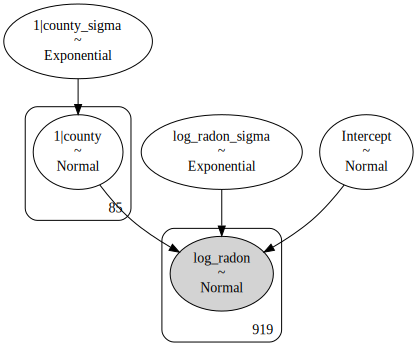

In [23]:
partial_pooling_model.graph()

We can clearly see a new hierarchical level as compared to the complete pooling model and unpooled model.

Next, we can plot the posterior distribution of the intercepts:

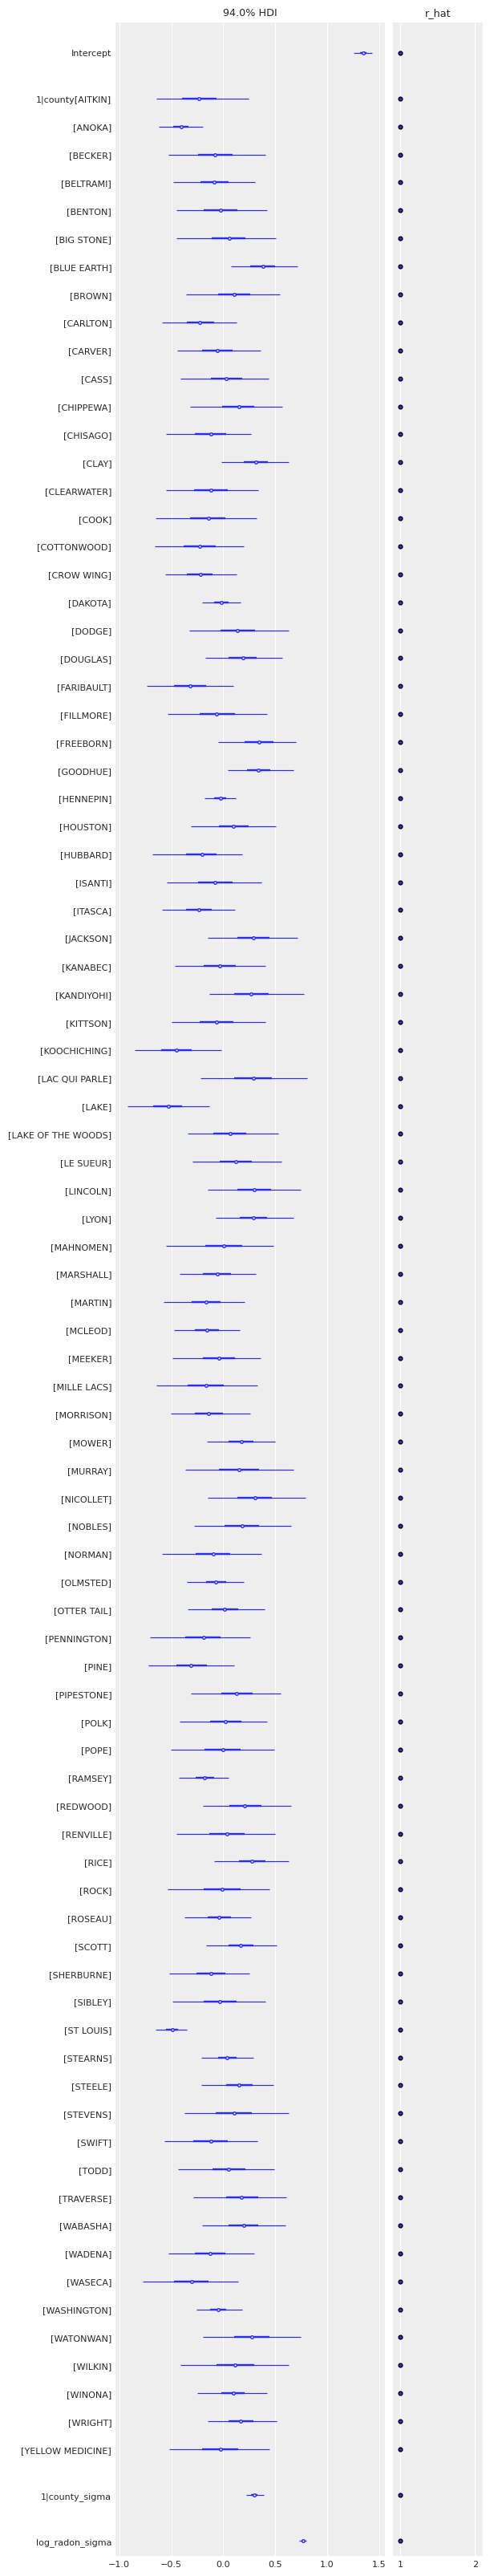

In [24]:
az.plot_forest(data=partial_pooling_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept Model

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

In [25]:
varying_intercept_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=10),
    "floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

varying_intercept_model = bmb.Model(
    "log_radon ~ 0 + floor + (1|county)",
    srrs_mn,
    priors=varying_intercept_priors,
 )

In [26]:
varying_intercept_results = varying_intercept_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, 1|county_offset, 1|county_sigma, floor]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


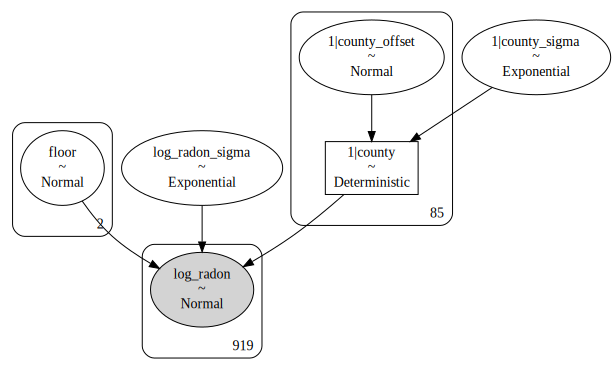

In [27]:
varying_intercept_model.graph()

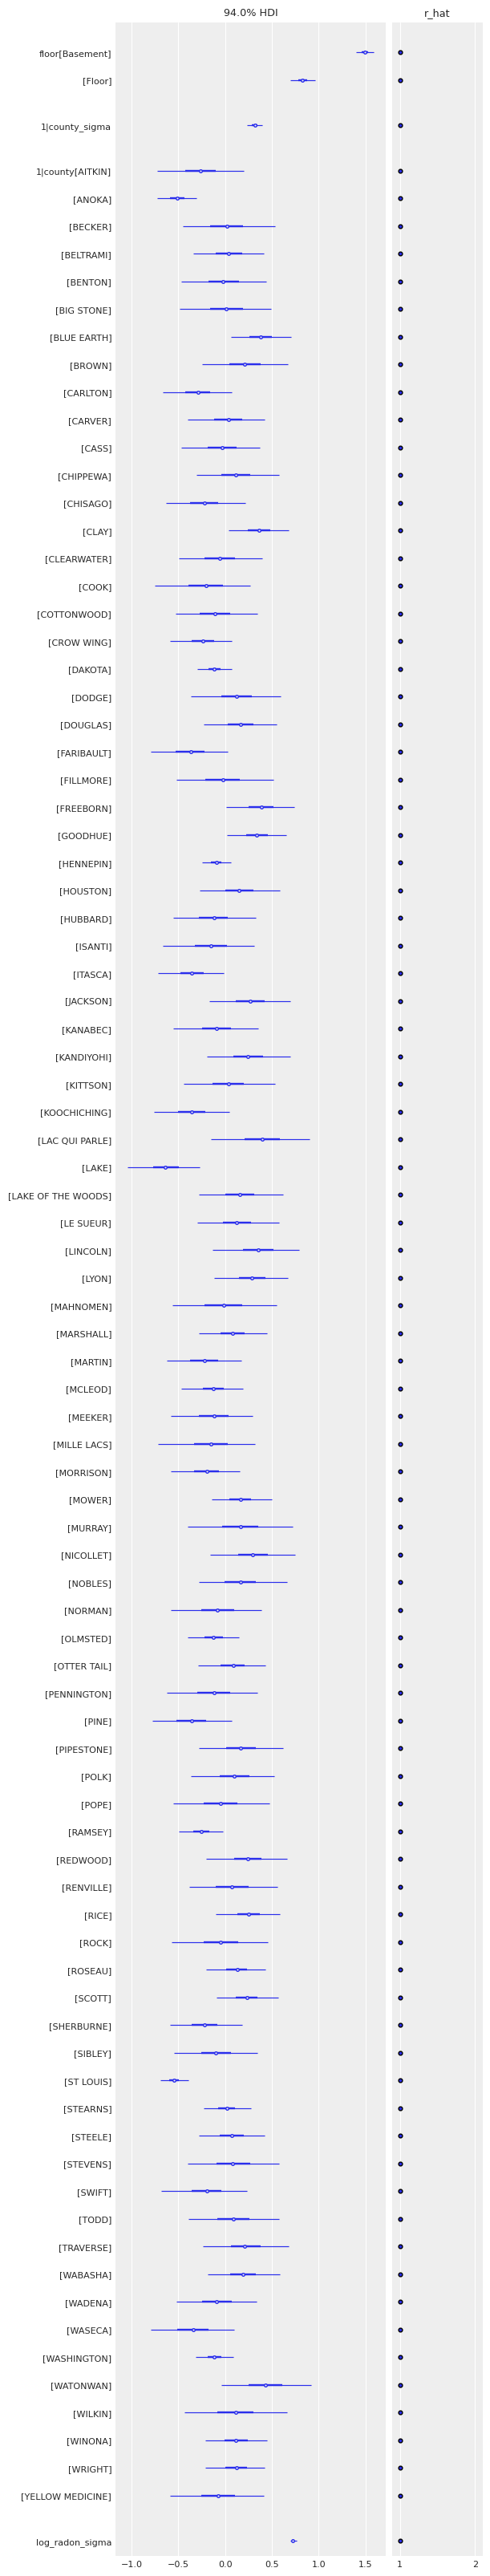

In [28]:
az.plot_forest(data=varying_intercept_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept and Slope Model

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

In [29]:
varying_intercept_slope_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "floor|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("Exponential", lam=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

varying_intercept_slope_model = bmb.Model(
    formula="log_radon ~ (floor|county)",
    data=srrs_mn,
    priors=varying_intercept_slope_priors,
 )

In [30]:
varying_intercept_slope_results = varying_intercept_slope_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, floor|county_offset, floor|county_sigma, 1|county_offset, 1|county_sigma, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


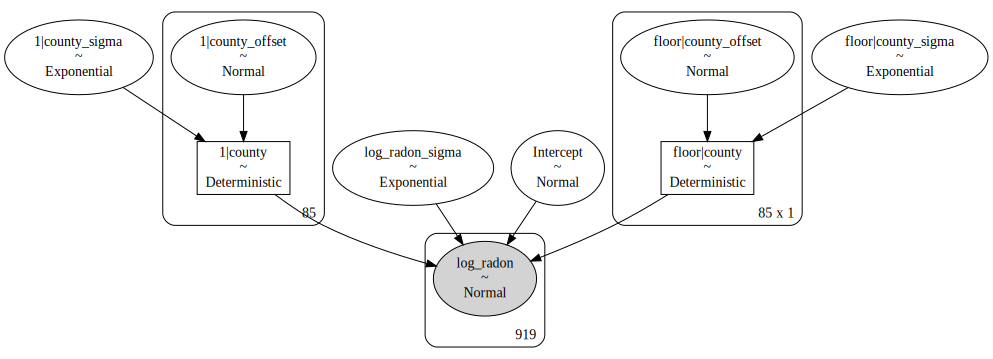

In [31]:
varying_intercept_slope_model.graph()

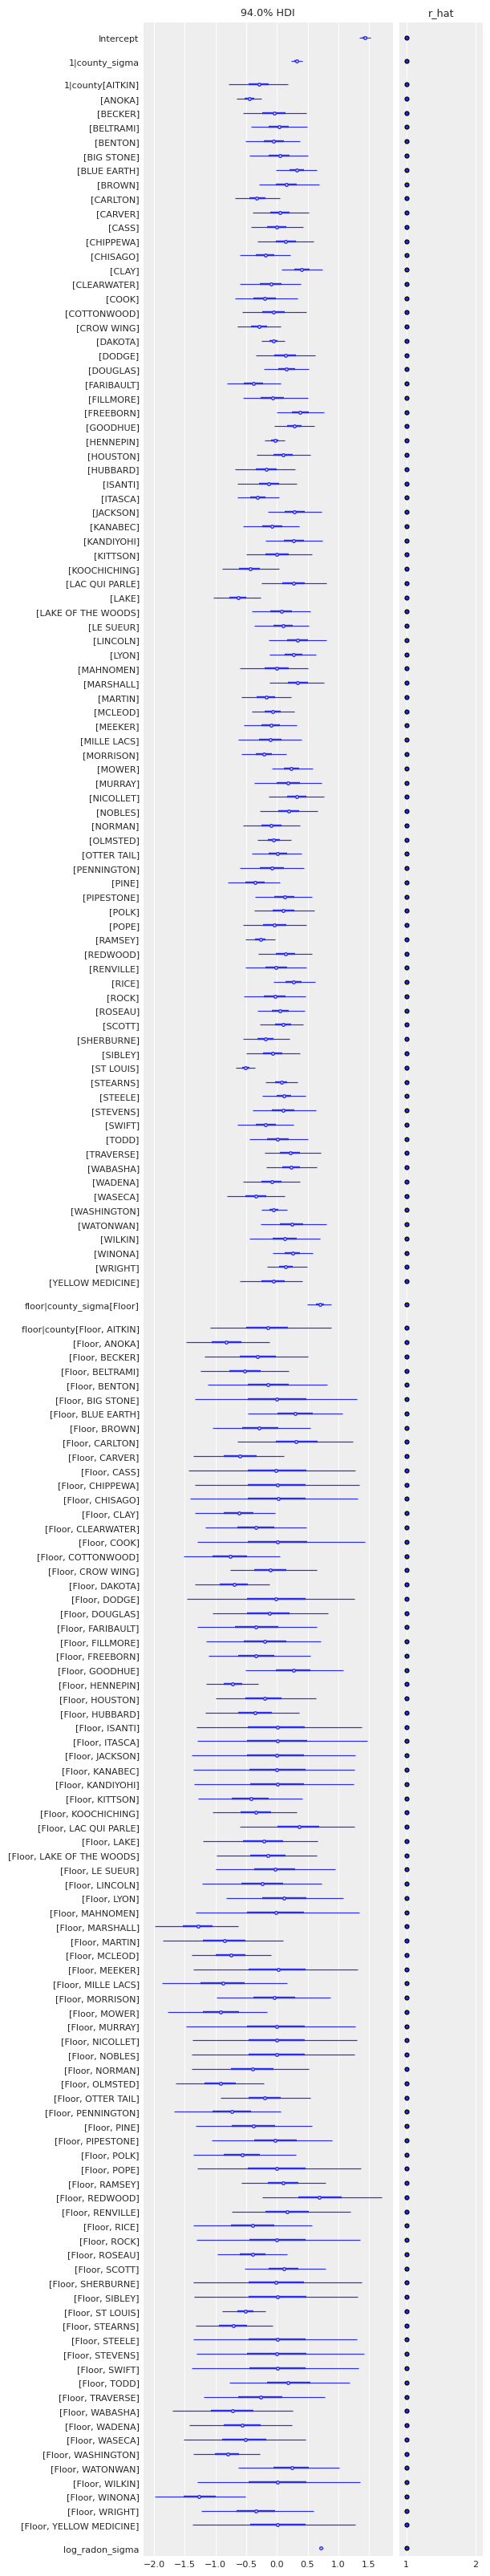

In [32]:
az.plot_forest(data=varying_intercept_slope_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

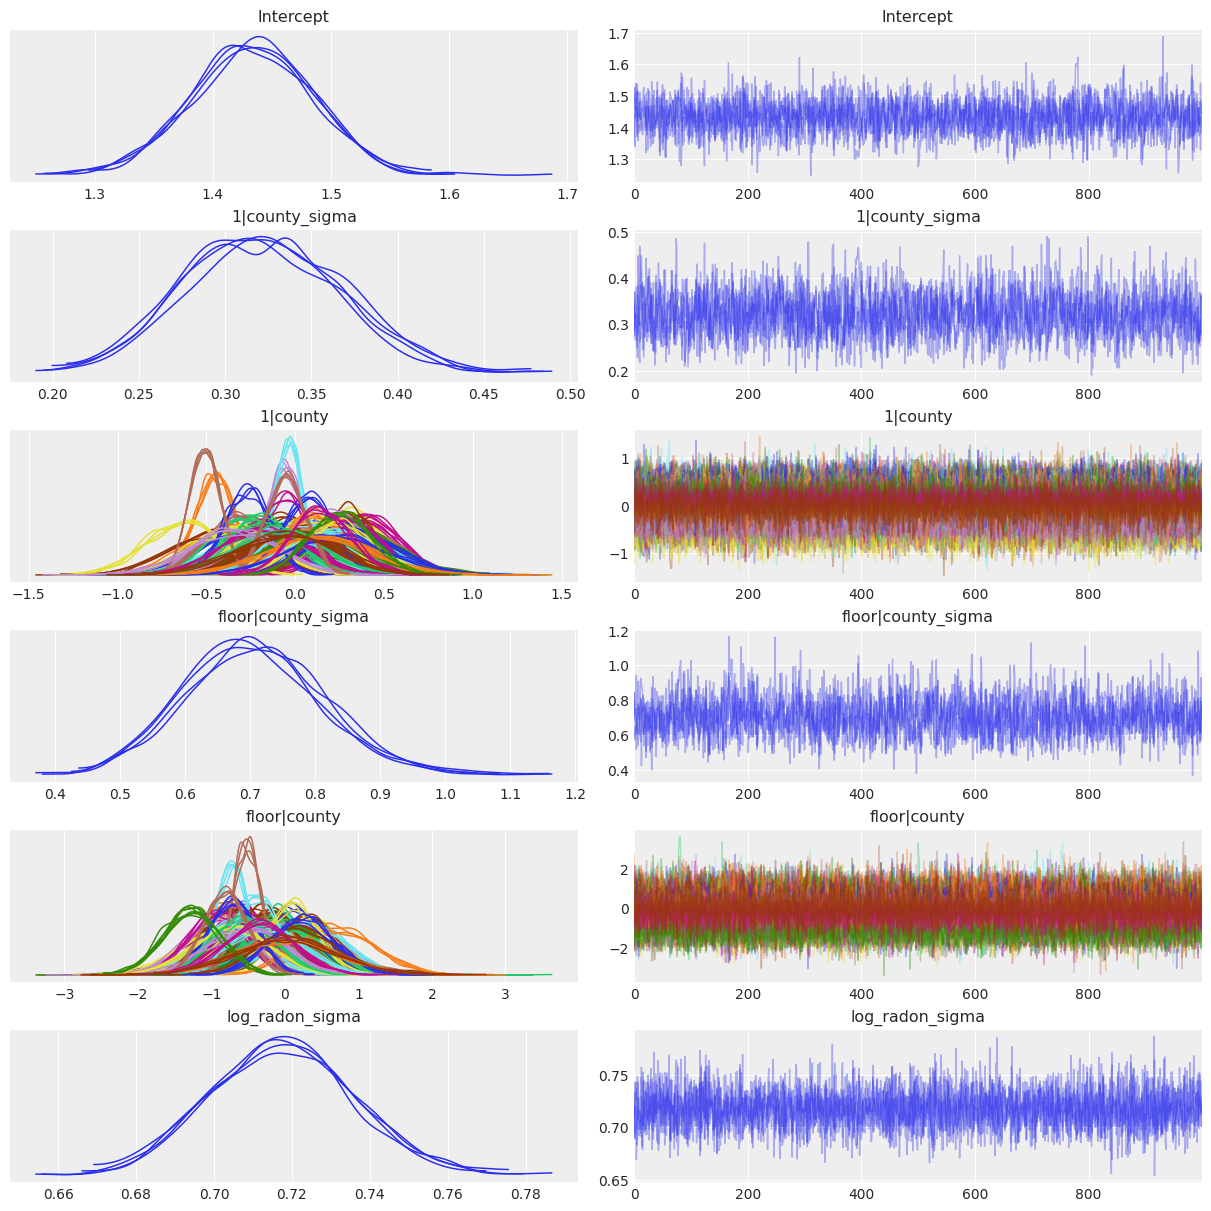

In [33]:
az.plot_trace(varying_intercept_slope_results, compact=True, chain_prop={"ls": "-"});

**NOTE:** We can do the following and it "works". But I wouldn't keep this in this notebook because it is still quite experimental and buggy. I'd prefer to fix the implementation and we can update the notebook after that.

In [34]:
priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "floor|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("HalfNormal", sigma=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

model = bmb.Model(
    formula="log_radon ~ (0 + floor|county)",
    data=srrs_mn,
    priors=priors,
    priors_cor={"county": 2}
 )

model.build()

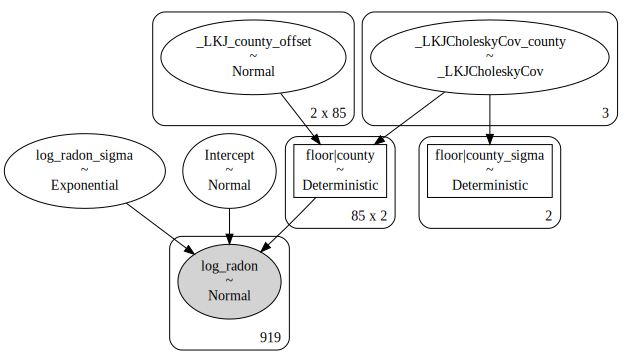

In [35]:
model.graph()

In [36]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, _LKJ_county_offset, _LKJCholeskyCov_county, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


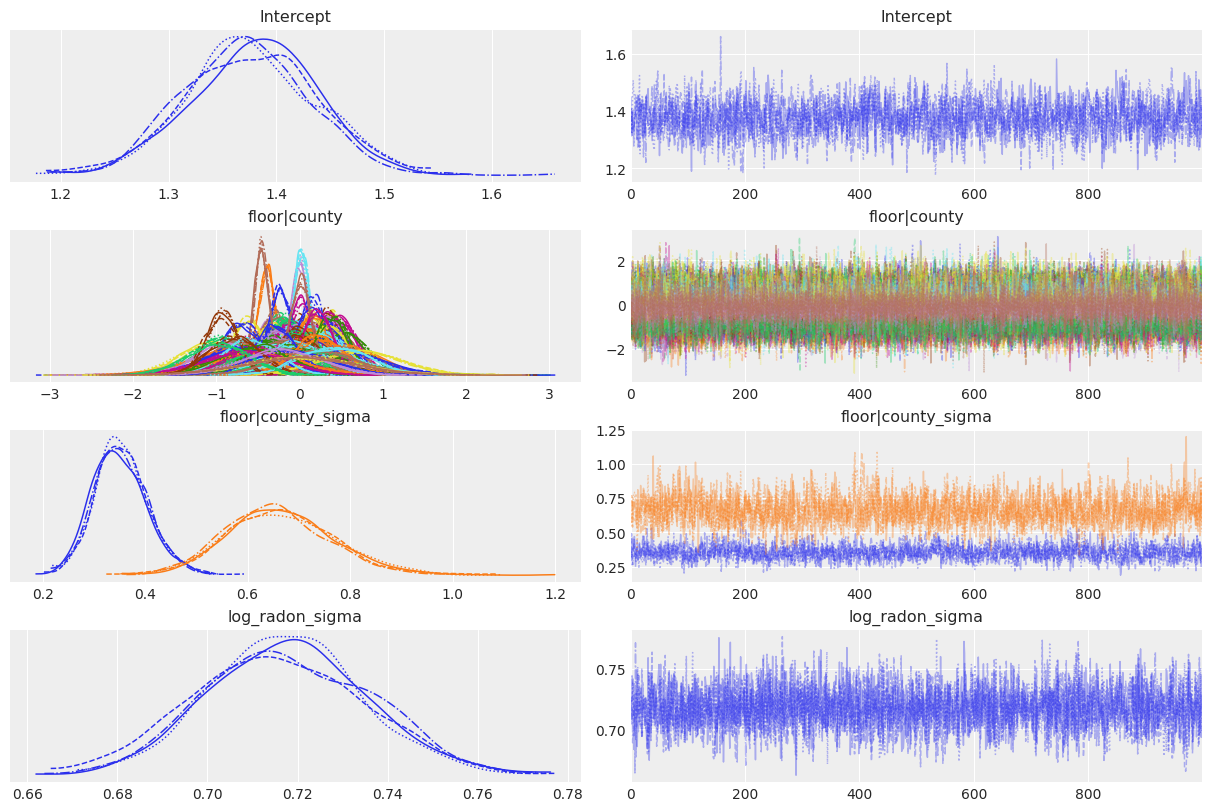

In [37]:
az.plot_trace(idata);